# Задание 5. Прогнозирование с помощью модели Хольта-Уинтерса

In [1]:
import os
os.chdir("C:/Users/HP/Documents/analysis/TS/data/")

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as dates

In [4]:
from pandas import read_csv
df = read_csv('task5.csv',parse_dates = True, index_col = 0,delimiter=';',decimal=',')
df.head()

,Рыночные цены на продукцию (руб.)
Дата,
2007-01-01,61.75
2007-02-01,58.66
2007-03-01,52.67
2007-04-01,42.45
2007-05-01,41.96


In [13]:
# Переименование столбцов
df_columns, df.columns = df.columns, ('y', )
df_index, df.index.name = df.index.name, 'date'
df.head()

,y
date,
2007-01-01,61.75
2007-02-01,58.66
2007-03-01,52.67
2007-04-01,42.45
2007-05-01,41.96


In [16]:
y = df.y.values
y

array([61.75, 58.66, 52.67, 42.45, 41.96, 39.6 , 38.81, 55.68, 59.22,
       63.95, 68.02, 73.18, 70.3 , 70.42, 62.79, 61.44, 54.06, 52.53,
       51.83, 56.19, 58.34, 67.29, 69.69, 74.07, 69.79, 69.61, 66.18,
       64.25, 59.43, 56.14, 60.45, 63.42, 67.83, 75.22, 78.68, 81.75,
       81.63, 80.44, 80.53, 75.52, 71.61, 65.58, 65.41, 67.65, 66.87,
       71.7 , 76.25, 82.23])

In [17]:
def holt(y, alpha, beta):
    y_history = [y[0]]
    level, trend = y[0], y[1] - y[0]
    for t in np.arange(1, len(y)):
        last_level, level = level, alpha*y[t] + (1 - alpha)*(level + trend)
        trend = beta*(level - last_level) + (1 - beta)*trend
        y_history.append(level + trend)
    return y_history

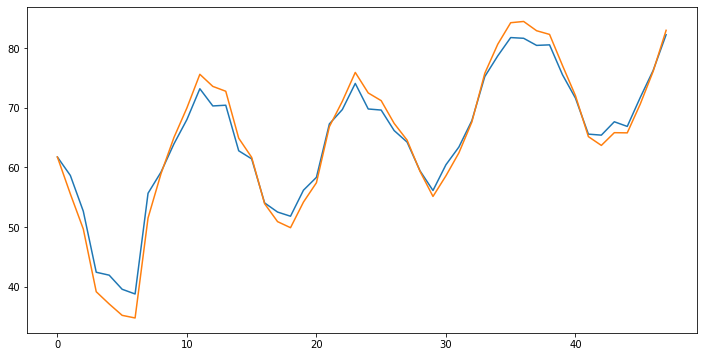

In [18]:
plt.figure(figsize=(12,6))
plt.plot(y)
plt.plot(holt(y, 0.8, 0.2))
plt.show()

In [19]:
def holt_winters(y, alpha, beta, gamma, lag):
    y_history = [y[lag]]
    level = y[lag] - y[0]
    trend = (y[lag] - y[0])
    seasonality = list(y[:lag])
    
    for t in np.arange(lag, len(y)):
        last_level, level = level, alpha*(y[t] - seasonality[t-lag]) + (1-alpha)*(level + trend)
        last_trend, trend = trend, beta*(level-last_level) + (1-beta)*trend
        seasonality.append(gamma*(y[t] - last_level - last_trend) + (1-gamma)*seasonality[t-lag])
        y_history.append(level + trend + seasonality[t-lag+1])
    return y_history

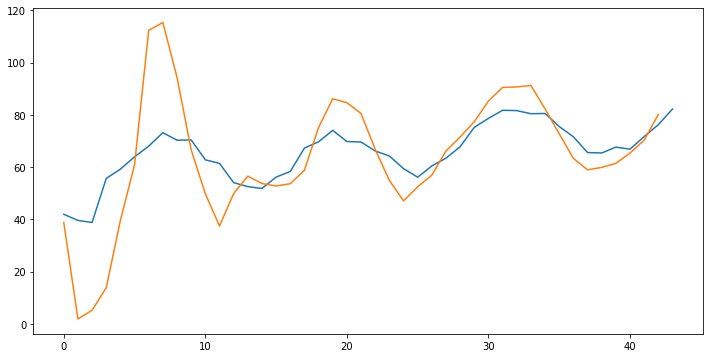

In [20]:
plt.figure(figsize=(12,6))
plt.plot(y[4:])
plt.plot(holt_winters(y, 0.35, 0.5, 0.4, lag=6))
plt.show()

In [25]:
def holt_wintersMsE(y, alpha, beta, gamma, lag):
    y_history = [y[lag]]
    level = y[lag] - y[0]
    trend = (y[lag] - y[0])
    seasonality = list(y[:lag])
    
    for t in np.arange(lag, len(y)):
        last_level, level = level, alpha*(y[t] - seasonality[t-lag]) + (1-alpha)*(level + trend)
        last_trend, trend = trend, beta*(level-last_level) + (1-beta)*trend
        seasonality.append(gamma*(y[t] - last_level - last_trend) + (1-gamma)*seasonality[t-lag])
        y_history.append(level + trend + seasonality[t-lag+1])
    return np.sum((y[lag:] - y_history[:-1]) ** 2)

In [26]:
from scipy.optimize import minimize
res = minimize(lambda x: holt_wintersMsE(y, x[0], x[1], x[2],lag=6), [1, 0.5, 1])

In [27]:
res.fun, res.x

(6186.407338903226, array([1.27906237, 0.18031632, 0.12863053]))

In [28]:
best_alpha, best_beta, best_gamme= res.x

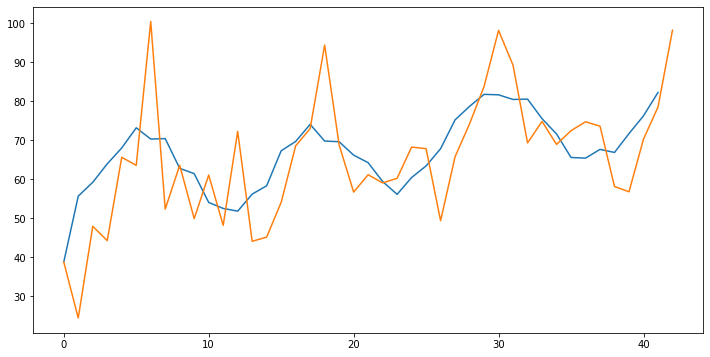

In [31]:
plt.figure(figsize=(12,6))
plt.plot(y[6:])
plt.plot(holt_winters(y, best_alpha, best_beta, best_gamme,lag=6))
plt.show()

# Способ 2

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller

In [43]:
data= pd.read_excel('data.xls', sheet_name='Prices')

In [44]:
dates = data.loc[data.index == 0].values[0, 2:]
val = data.loc[data.index == 1].values[0, 2:]

In [45]:
df = pd.DataFrame(data={"Value": val},index=dates)
df.head()

,Value
2007-01-01,61.75
2007-02-01,58.66
2007-03-01,52.67
2007-04-01,42.45
2007-05-01,41.96


In [46]:
len(df)

48

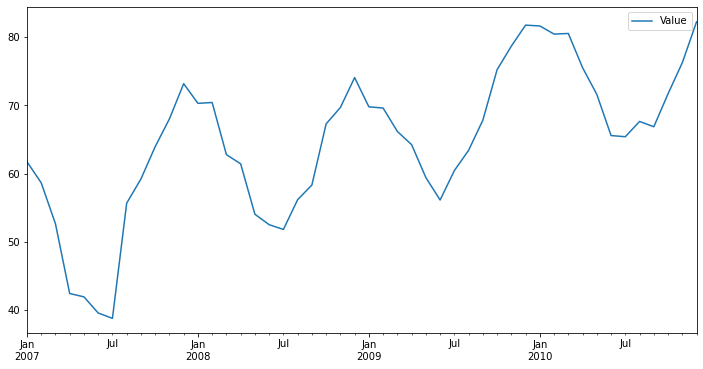

In [47]:
df.plot(figsize=(12,6))
plt.show()

C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


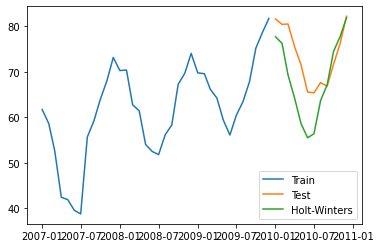

In [48]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train, test = df.iloc[:36], df.iloc[36:]
model = ExponentialSmoothing(train.values, seasonal='mul', seasonal_periods=12).fit()
pred = model.predict(start=len(train), end=len(test)+len(train)-1)

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, pred, label='Holt-Winters')
plt.legend(loc='best')

In [49]:
model.summary()

Dep. Variable:,endog,No. Observations:,36
Model:,ExponentialSmoothing,SSE,289.161
Optimized:,True,AIC,103.005
Trend:,None,BIC,125.174
Seasonal:,Multiplicative,AICC,131.636
Seasonal Periods:,12,Date:,"Mon, 23 Aug 2021"
Box-Cox:,False,Time:,11:45:41
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8332337,alpha,True
smoothing_seasonal,4.2844e-09,gamma,True


# Способ 3

In [50]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as dates

In [51]:
from pandas import read_csv
df = read_csv('task5.csv',parse_dates = True, index_col = 0,delimiter=';',decimal=',')
df.head()

,Рыночные цены на продукцию (руб.)
Дата,
2007-01-01,61.75
2007-02-01,58.66
2007-03-01,52.67
2007-04-01,42.45
2007-05-01,41.96


In [52]:
df.columns = ['y']

In [53]:
df.describe()

,y
count,48.000000
mean,64.647292
std,10.982245
min,38.810000
25%,58.580000
50%,65.880000
75%,71.632500
max,82.230000


### График временного ряда

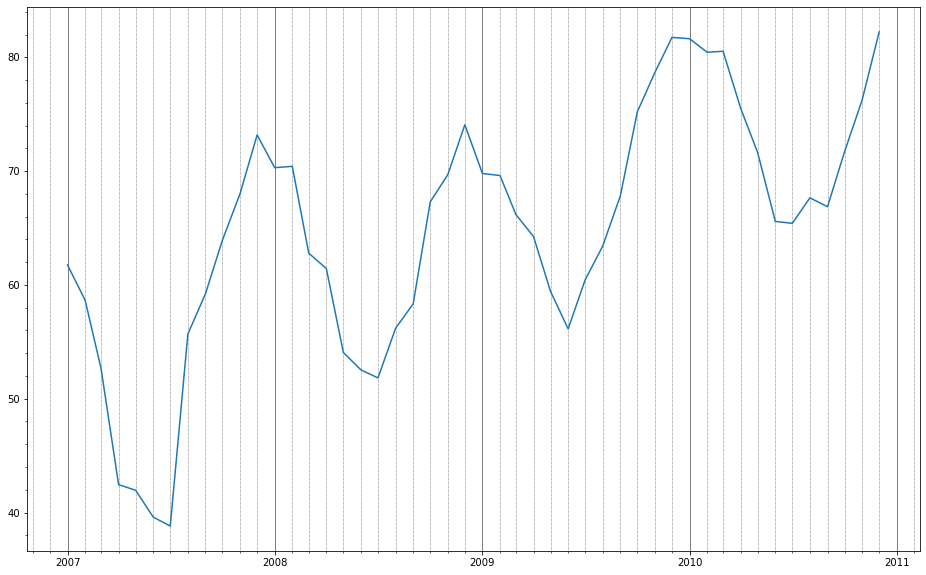

In [54]:
fig, ax = plt.subplots(figsize = (16, 10))

ax.plot(df)

ax.grid(which = 'major', axis = 'x', linestyle = '-', linewidth = '0.5', color = 'black')
ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))

ax.minorticks_on()
ax.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = '0.5', color = 'black')
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonth = range(1, 13)))

ax.set_axisbelow(True)

plt.show()

In [55]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [57]:
arr = df['y']
df.index = pd.DatetimeIndex(df.index.values, freq='MS')

In [58]:
model = ExponentialSmoothing(df, trend = 'add', seasonal = 'mul', damped = True).fit()
forecast = model.forecast(12)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  """Entry point for launching an IPython kernel.
C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [59]:
def RSME(ts1, ts2):
    return np.sqrt(np.sum(np.power(ts1 - ts2, 2)) / len(ts1))

In [60]:
RSME(model.fittedvalues, arr)

3.8176331761239726

In [61]:
model.params_formatted

,name,param,optimized
smoothing_level,alpha,1.416628e-07,True
smoothing_trend,beta,8.038627e-08,True
smoothing_seasonal,gamma,3.368811e-12,True
initial_level,l.0,5.718700e+01,True
initial_trend,b.0,1.121473e+00,True
damping_trend,phi,9.719939e-01,True
initial_seasons.0,s.0,9.772383e-01,True
initial_seasons.1,s.1,9.551884e-01,True
initial_seasons.2,s.2,8.937797e-01,True
initial_seasons.3,s.3,8.278694e-01,True


### Построим график исходного временного ряда, смоделированный ряд и прогноз

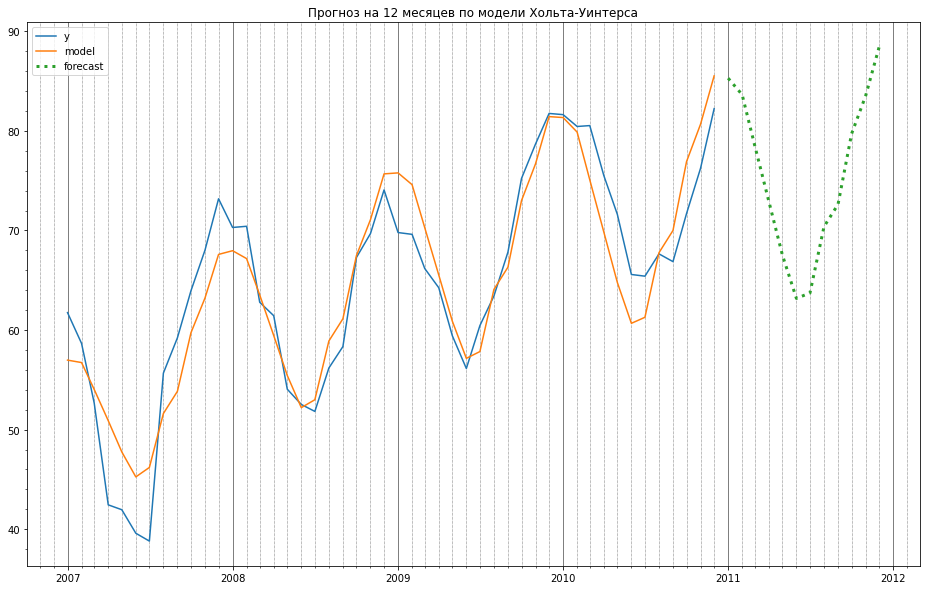

In [62]:
fig, ax = plt.subplots(figsize = (16, 10))

ax.plot(df, label = 'y')

ax.plot(model.fittedvalues, label = 'model')

ax.plot(forecast, label = 'forecast', linestyle = ':', linewidth = '3')

ax.grid(which = 'major', axis = 'x', linestyle = '-', linewidth = '0.5', color = 'black')
ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))

ax.minorticks_on()
ax.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = '0.5', color = 'black')
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonth = range(1, 13)))

ax.set_axisbelow(True)

ax.legend()

plt.title('Прогноз на 12 месяцев по модели Хольта-Уинтерса')

plt.show()

In [63]:
forecast

2011-01-01    85.289139
2011-02-01    83.631028
2011-03-01    78.496629
2011-04-01    72.926092
2011-05-01    67.531610
2011-06-01    63.177893
2011-07-01    63.727526
2011-08-01    70.381200
2011-09-01    72.617447
2011-10-01    79.704513
2011-11-01    83.505255
2011-12-01    88.430548
Freq: MS, dtype: float64